# Text mining

## Appuie pour faire tourner les fonctions

### Config

Les modules à installer se trouvent dans requirements.txt

Import and download

In [32]:
import json
import os
import re
import csv
import string
import nltk 
import numpy as np
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>
[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>
[nltk_data] Error loading punkt_tab: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>


False

Configuration

In [33]:
STOP_WORDS = set(stopwords.words('english')) | set(string.punctuation)
STEMMER = nltk.stem.SnowballStemmer('english')
SIA = SentimentIntensityAnalyzer()

### Fonctions utilitaires

Chargement du fichier de contenu

In [34]:
def load_data(content_path, links_path):
    if not os.path.exists(content_path):
        raise FileNotFoundError(f"Le fichier '{content_path}' est introuvable.")
    with open(content_path, 'r', encoding='utf-8') as file:
        content = json.load(file)
    if not os.path.exists(links_path):
        raise FileNotFoundError(f"Le fichier '{links_path}' est introuvable.")
    with open(links_path, 'r', encoding='utf-8') as file:
        links = json.load(file)
    
    return content, links

Sauvegarde des données

In [35]:
os.makedirs('output', exist_ok=True)

def save_to_file(data, filename):
    if isinstance(data, np.ndarray):
        np.savetxt(f'output/{filename}.txt', data, fmt='%.4f')
    elif isinstance(data, dict):
        with open(f'output/{filename}.json', 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=4)
    elif isinstance(data, list):
        with open(f'output/{filename}.txt', 'w', encoding='utf-8') as f:
            for line in data:
                f.write(line + '\n')


JSON TO GML

In [36]:
def json_to_gml (links_path, output_file):
    with open(links_path, "r", encoding="utf-8") as file:
        links_path = json.load(file)
    nodes = set()
    edges = []
    # Parcourir les liens et extraire les nœuds et les connexions
    for source, targets in links_path.items():
        nodes.add(source)
        for target in targets:
            nodes.add(target)
            edges.append((source, target))

    # Étape 3 : Assigner des ID aux nœuds (sans utiliser enumerate)
    node_id = {}
    current_id = 0
    for node in nodes:
        node_id[node] = current_id
        current_id += 1

    # Étape 4 : Écrire le fichier GML
    with open(output_file, "w", encoding="utf-8") as file:
        file.write("graph\n")
        file.write("[\n")
        file.write("  directed 1\n")  # Graph orienté

        # Ajouter les nœuds
        for node, id in node_id.items():
            file.write("  node\n")
            file.write("  [\n")
            file.write(f"    id {id}\n")
            file.write(f"    label \"{node}\"\n")
            file.write("  ]\n")

        # Ajouter les arêtes
        for source, target in edges:
            file.write("  edge\n")
            file.write("  [\n")
            file.write(f"    source {node_id[source]}\n")
            file.write(f"    target {node_id[target]}\n")
            file.write("  ]\n")

        file.write("]\n")

    print(f"Fichier GML créé : {output_file}")

Traitement du contenu texte

In [37]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [STEMMER.stem(token) for token in tokens if token not in STOP_WORDS and len(token) > 2]
    return tokens

Sauvegarder tous les tokens

In [38]:
def clean_and_save_tokens(content, output_file):
    cleaned_data = {}

    for page_title, page_content in content.items():
        tokens = preprocess_text(page_content)
        cleaned_data[page_title] = tokens

    save_to_file(cleaned_data, output_file)

Traitement de texte spécifique à SIA, pour éviter de supprimer les "not" et autres

In [39]:
def preprocess_SIA(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    return tokens

Liste des tokens

In [40]:
def tokenize_corpus(corpus):
    all_tokens = []
    for content in corpus.values():
        all_tokens.extend(preprocess_text(content))
    return all_tokens

Entrainement des modèles tfidfj et doc2vec

In [41]:
# 1. Entraînement du modèle Doc2Vec
def train_doc2vec_model(documents, vector_size=100, window=1, epochs=20):
    tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()), tags=[str(i)]) for i, doc in enumerate(documents)]
    model = Doc2Vec(tagged_data, vector_size=vector_size, window=2, min_count=1, workers=4, epochs=epochs)
    return model

# 2. Entraînement du modèle TF-IDF
def train_tfidf_model(documents):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(documents)
    return tfidf_matrix

### Différents modèles de text mining

Trouver les phrases comprenant un ou des mots

In [ ]:
def find_sentences_with_words(corpus, words):
    sentences_with_words = []
    
    # Normaliser les mots recherchés (racines)
    stemmed_words = [STEMMER.stem(word.lower()) for word in words]
    
    for content in corpus.values():
        # Découper le contenu en phrases
        sentences = sent_tokenize(content)
        
        for sentence in sentences:
            # Tokeniser la phrase et normaliser les tokens
            tokens = word_tokenize(sentence.lower())
            stemmed_tokens = [STEMMER.stem(token) for token in tokens]
            # Vérifier si toutes les racines des mots recherchés sont présentes
            if all(word in stemmed_tokens for word in stemmed_words):
                sentences_with_words.append(sentence)
    
    return sentences_with_words


    

Analyse de sentiment

In [102]:
def analyze_word_sentiment(sentences):
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = {"positive": 0, "negative": 0, "neutral": 0, "compound": 0}
    for sentence in sentences:
        scores = sia.polarity_scores(sentence)
        sentiment_scores["positive"] += scores["pos"]
        sentiment_scores["negative"] += scores["neg"]
        sentiment_scores["neutral"] += scores["neu"]
        sentiment_scores["compound"] += scores["compound"]

    # Moyenne des scores
    num_sentences = len(sentences)
    if num_sentences > 0:
        sentiment_scores = {key: value / num_sentences for key, value in sentiment_scores.items()}

    # Déterminer le sentiment principal
    if sentiment_scores["positive"] > sentiment_scores["negative"] and sentiment_scores["positive"] > sentiment_scores["neutral"]:
        sentiment = "Positif"
    elif sentiment_scores["negative"] > sentiment_scores["positive"] and sentiment_scores["negative"] > sentiment_scores["neutral"]:
        sentiment = "Négatif"
    else:
        sentiment = "Neutre"

    return sentiment_scores, sentiment

def word_sentiment_analysis(content, word):
    print(word)
    # Trouver les phrases contenant le mot
    sentences_with_word = find_sentences_with_words(content, word)
    print(sentences_with_word)
    if not sentences_with_word:
        print(f"Le mot '{word}' n'a pas été trouvé dans le corpus.")
        return {
            "word": word,
            "sentences_with_word": [],
            "sentiment_scores": {"positive": 0, "negative": 0, "neutral": 0, "compound": 0},
            "overall_sentiment": "Aucun (mot non trouvé)"
        }

    # Analyser le sentiment des phrases
    sentiment_scores, sentiment = analyze_word_sentiment(sentences_with_word)

    return {
        "word": word,
        "sentences_with_word": sentences_with_word,
        "sentiment_scores": sentiment_scores,
        "overall_sentiment": sentiment
    }

def analyze_page_sentiment(page_name, content):
    if page_name not in content:
        return f"La page '{page_name}' n'existe pas dans le corpus."

    page_content = content[page_name]
    sentences = sent_tokenize(page_content)
    sentiment_scores, overall_sentiment = analyze_word_sentiment(sentences)

    # Ajout pour cas neutre avec consonance
    if overall_sentiment == "Neutre":
        if sentiment_scores["positive"] > sentiment_scores["negative"]:
            overall_sentiment = "Neutre avec consonance plus positive"
        elif sentiment_scores["negative"] > sentiment_scores["positive"]:
            overall_sentiment = "Neutre avec consonance plus négative"

    return {
        "page_name": page_name,
        "sentiment_scores": sentiment_scores,
        "overall_sentiment": overall_sentiment
    }




Bigrammes

In [44]:
def find_cooccurrences(corpus_path, keyword, min_freq=2, window_size=5):
    # Charger et prétraiter le corpus
    with open(corpus_path, 'r', encoding='utf-8') as file:
        corpus = json.load(file)
    
    all_tokens = []
    for text in corpus.values():
        all_tokens.extend(preprocess_text(text))
    
    # Trouver les bigrammes avec la librairie NLTK
    bigram_measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(all_tokens, window_size=window_size)
    finder.apply_freq_filter(min_freq)
    
    # Filtrer les bigrammes contenant le mot-clé
    keyword_stem = STEMMER.stem(keyword)
    relevant_bigrams = {}
    for bigram, freq in finder.ngram_fd.items():
        if keyword_stem in bigram:
            distances = []
            for i in range(len(all_tokens) - 1):
                if all_tokens[i] == bigram[0] and bigram[1] in all_tokens[i + 1:i + window_size + 1]:
                    j = all_tokens.index(bigram[1], i + 1, i + window_size + 1)
                    distances.append(abs(j - i))
            relevant_bigrams[bigram] = {
                "frequency": freq,
                "mean_distance": sum(distances) / len(distances) if distances else 0
            }
    
    # Trier les résultats
    sorted_bigrams = sorted(relevant_bigrams.items(), key=lambda item: item[1]['frequency'], reverse=True)
    
    # Afficher les résultats
    print(f"Cooccurrences pour le mot-clé '{keyword}':\n")
    print(f"{'Cooccurrence':<20}\t{'Frequency':<10}\t{'Mean Distance':<15}")
    print(f"{'-' * 60}")
    for bigram, data in sorted_bigrams:
        print(f"{bigram[0]} {bigram[1]:<17}\t{data['frequency']:<10}\t{data['mean_distance']:<15.2f}")
    
    return sorted_bigrams

Analyse des tokens

In [45]:
def show_top_tokens(corpus, top_n=20):
    all_tokens = tokenize_corpus(corpus)
    freq_dist = nltk.FreqDist(all_tokens)
    return freq_dist.most_common(top_n)

Wordcloud

In [46]:
def generate_wordcloud(corpus, output_filename='wordcloud.png'):
    all_tokens = tokenize_corpus(corpus)
    text = ' '.join(all_tokens)
    wordcloud = WordCloud(background_color='white', stopwords=STOP_WORDS, max_words=30, min_font_size=10).generate(text)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(f'output/{output_filename}', format='png')
    plt.show()

Tableau des tops tokens 

In [47]:
def generate_token_table(json_path, output_csv):
    STOP_WORDS = set(stopwords.words('english')) | set(string.punctuation)
    STEMMER = SnowballStemmer('english')
    with open(json_path, 'r', encoding='utf-8') as file:
        content = json.load(file)
    token_counts = {}  # Dictionnaire pour les occurrences
    document_counts = defaultdict(int)  # Nombre de documents contenant chaque token
    word_map = defaultdict(set)  # Mots originaux associés aux tokens stemmés


    for text in content.values():
        tokens = word_tokenize(text.lower())
        stemmed_tokens = [STEMMER.stem(token) for token in tokens if token.isalnum() and token not in STOP_WORDS]
        #Compter les occurrences globales
        for token in stemmed_tokens:
            if token in token_counts:
                token_counts[token] += 1
            else:
                token_counts[token] = 1

        #Compter les documents contenant chaque token (uniquement une fois par document)
        unique_tokens = set(stemmed_tokens)
        for token in unique_tokens:
            document_counts[token] += 1

        #Mapper les mots originaux aux tokens stemmés
        for word in tokens:
            if word.isalnum() and word not in STOP_WORDS:
                stemmed = STEMMER.stem(word)
                word_map[stemmed].add(word)

    # Construire et sauvegarder le tableau en une étape
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)
    with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        
        # Écrire l'en-tête
        writer.writerow(["Token (stemmatisé)", "Mots associés", "Occurrences", "Articles concernés"])
        
        # Écrire les données
        for token, freq in token_counts.items():
            writer.writerow([
                token,
                ', '.join(word_map[token]),  # Convertir les mots associés en chaîne de caractères
                freq,
                document_counts[token]
            ])
    print(f"Tableau sauvegardé dans {output_csv}")


Calcul de similarité entre 2 documents au choix


In [48]:
def calculate_similarity(model, doc_id1, doc_id2):
    vec1 = model.dv[doc_id1]
    vec2 = model.dv[doc_id2]
    return cosine_similarity([vec1], [vec2])[0][0]

Recherche de documents similaires

In [49]:
def find_similar_docs(model, doc_id, top_n=5):
    return model.dv.most_similar(str(doc_id), topn=top_n)

### Clustering

Matrice de similarité par cosinus

In [50]:
def calculate_cosine_similarity(content, model):
    # Obtenir les vecteurs des documents
    doc_vectors = np.array([model.dv[i] for i in range(len(content))])  # Convertir en matrice NumPy

    # Calcul de la matrice de similarité par le cosinus
    similarity_matrix = cosine_similarity(doc_vectors)

    # Sauvegarder la matrice de similarité dans un fichier
    save_to_file(similarity_matrix, 'similarity_matrix.json')  # Sauvegarde en JSON

    return similarity_matrix

Nombre optimal de clusters

In [51]:
def find_optimal_clusters(vectors, max_clusters=10, min_clusters=2):
    scores = []
    for k in range(min_clusters, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(vectors)
        scores.append(silhouette_score(vectors, labels))

    return np.argmax(scores) + min_clusters

Clusters

In [52]:
def cluster_documents(content, optimal_k):

    # Préparer les documents
    documents = list(content.values())

    # Entraîner le modèle Doc2Vec
    model = train_doc2vec_model(documents, vector_size=100, window=2, epochs=40)

    # Obtenir les vecteurs des documents
    doc_vectors = [model.dv[i] for i in range(len(content))]

    # Appliquer KMeans
    kmeans = KMeans(n_clusters=optimal_k, max_iter=100, n_init=10, random_state=42)
    kmeans.fit(doc_vectors)

    clusters = {}
    for i, doc in enumerate(doc_vectors):
        cluster_label = int(kmeans.labels_[i])
        document_key = list(content.keys())[i]  # Utilisation de la clé du dictionnaire
        if cluster_label not in clusters:
            clusters[cluster_label] = []
        clusters[cluster_label].append(document_key)

    # Sauvegarder les clusters
    save_to_file(clusters, 'clusters')
    
    # Créer un fichier texte avec les titres des documents regroupés par clusters
    with open('output/clusters_titles.txt', 'w', encoding='utf-8') as f:
        for cluster_label, docs in clusters.items():
            f.write(f"Cluster {cluster_label}:\n")
            for doc in docs:
                f.write(f"- {doc}\n")
            f.write("\n")

    # Calcul et sauvegarde de la matrice de similarité
    similarity_matrix = calculate_cosine_similarity(content, model)

    return clusters, similarity_matrix

Sauvegarde les titres complets des documents dans chaque cluster dans un fichier

In [53]:
def save_clusters_individually(clusters, content_path):
    # Charger le contenu à partir du fichier JSON
    with open(content_path, 'r', encoding='utf-8') as f:
        content = json.load(f)

    # Créer un dossier pour stocker les fichiers des clusters
    os.makedirs('output/clusters', exist_ok=True)
    
    # Sauvegarder chaque cluster dans un fichier JSON séparé
    for cluster_label, docs in clusters.items():
        cluster_content = {doc: content[doc] for doc in docs}  # Documents de ce cluster
        output_file = f'output/clusters/cluster_{cluster_label}.json'  # Nom du fichier JSON
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(cluster_content, f, ensure_ascii=False, indent=4)
        print(f"Cluster {cluster_label} sauvegardé dans {output_file}")


Links par clusters

In [54]:
def create_links_per_cluster(clusters_dir, original_links_path, output_dir):
    # Charger les liens originaux
    with open(original_links_path, 'r', encoding='utf-8') as f:
        original_links = json.load(f)

    # Créer un répertoire pour stocker les nouveaux fichiers
    os.makedirs(output_dir, exist_ok=True)

    # Parcourir tous les fichiers de clusters dans le répertoire spécifié
    for cluster_file in os.listdir(clusters_dir):
        cluster_path = os.path.join(clusters_dir, cluster_file)

        # Charger le fichier du cluster
        with open(cluster_path, 'r', encoding='utf-8') as f:
            cluster_nodes = json.load(f)

        # Préparer un dictionnaire pour les liens de ce cluster
        cluster_links = {}

        # Parcourir les nœuds du cluster et ajouter leurs liens
        for node in cluster_nodes:
            if node in original_links:
                cluster_links[node] = [
                    target for target in original_links[node] if target in cluster_nodes
                ]

        # Nommer le fichier de sortie basé sur le fichier du cluster
        cluster_label = os.path.splitext(cluster_file)[0]
        output_path = os.path.join(output_dir, f"{cluster_label}_links.json")

        # Sauvegarder les liens filtrés dans un fichier JSON
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(cluster_links, f, ensure_ascii=False, indent=4)

        print(f"Fichier de liens créé pour le cluster : {output_path}")

Graph de similarité

In [55]:
def generate_similarity_graph(content, similarity_matrix, output_file):
    G = nx.Graph()

    # Ajouter les nœuds
    for page in content.keys():
        G.add_node(page)

    # Ajouter les arêtes pondérées par les similarités textuelles
    pages = list(content.keys())
    for i in range(len(pages)):
        for j in range(i + 1, len(pages)):
            similarity = similarity_matrix[i, j]
            if similarity > 0:  # Ajouter une arête seulement si la similarité est positive
                G.add_edge(pages[i], pages[j], weight=similarity)

    # Sauvegarder le graphe en format GML
    nx.write_gml(G, output_file)
    print(f"Graphe de similarité créé : {output_file}")

## Choisis ce que tu veux lancer

Chemin du fichier

In [56]:
if __name__ == '__main__':
    content_path = 'content3.json'
    links_path = 'links3.json'
    content, links = load_data(content_path, links_path)

entrainer le modèle

In [57]:
model = train_doc2vec_model(content, vector_size=100, window=2, epochs=40)
tfidf_matrix = train_tfidf_model(content)

Phrases content un/des mots

In [109]:
words_to_find = ['diversity', 'inclusion']
sentences = find_sentences_with_words(content, words_to_find)
for sentence in sentences:
    print(sentence)

In the deficit model, it is believed that organizations that do not have a strong diversity inclusion culture will invite lower productivity, higher absenteeism, and higher turnover which will result in higher costs to the company.
Even though Diversity, Equity, and Inclusion are three interconnected concepts represented by the abbreviation DE&I, they are not interchangeable.
Diversity without equity and inclusion is often perceived as "tokenism".
Page points out, however, that diversity in teamwork is not always simple and that there are many challenges to fostering an inclusive environment in the workplace for diversity of thought and ideas.
Following the murder of George Floyd in 2020, many companies made substantial commitments to racial equity by establishing dedicated diversity, equity, and inclusion teams.
Diversity inclusion initiatives must start with the commitment from the top.
With a commitment from top leaders in an organization to change the existing culture to one of div

Analyse de sentiment

In [112]:
  
result = word_sentiment_analysis(content, ["marketing"])

print(f"Analyse de sentiment pour le mot '{result['word']}':")
print(f"Scores moyens : {result['sentiment_scores']}")
print(f"Sentiment global : {result['overall_sentiment']}")
print("\nExemples de phrases contenant le mot :")
for sentence in result["sentences_with_word"][:5]:  # Afficher jusqu'à 5 phrases
    print(f"- {sentence}")

['marketing']
['== Purported Benefits ==\nDiversity is believed by some to bring substantial benefits such as better decision making and improved problem solving, greater creativity and innovation, which leads to enhanced product development, and more successful marketing to different types of customers.', "Diversity is also claimed to enhance organizations' abilities to compete in global markets.", 'The aim of the liberal change model is to have a fair labor market from which the best person is chosen for a job based solely on performance.', '== Implementation ==\n\nIntentional "diversity programs" can assist organizations facing rapid demographic changes in their local consumer market and labor pool by helping people work and understand one another better.', 'The variation in skills and productivity between groups of people ultimately caused disparities in employment, occupation and income within labour markets, which provided advantages to certain groups and characteristics of peopl

Sauvegarder les tokens

In [60]:
output_file = 'cleaned_data'
clean_and_save_tokens(content, output_file)

Bigrammes

In [61]:
corpus_path = 'content3.json'  # Remplacez par votre fichier JSON
keyword = "diversity"         # Mot-clé à analyser
find_cooccurrences(corpus_path, keyword, min_freq=47, window_size=5)

Cooccurrences pour le mot-clé 'diversity':

Cooccurrence        	Frequency 	Mean Distance  
------------------------------------------------------------
cultur divers           	230       	1.35           
divers inclus           	192       	1.82           
divers equiti           	134       	1.54           
divers divers           	114       	3.39           
divers train            	102       	1.30           
divers cultur           	83        	2.41           
promot divers           	61        	1.97           
divers manag            	51        	2.06           
divers statement        	48        	1.08           
divers hire             	47        	2.14           


[(('cultur', 'divers'),
  {'frequency': 230, 'mean_distance': 1.3484162895927603}),
 (('divers', 'inclus'),
  {'frequency': 192, 'mean_distance': 1.8238341968911918}),
 (('divers', 'equiti'),
  {'frequency': 134, 'mean_distance': 1.5416666666666667}),
 (('divers', 'divers'),
  {'frequency': 114, 'mean_distance': 3.3896103896103895}),
 (('divers', 'train'),
  {'frequency': 102, 'mean_distance': 1.3010752688172043}),
 (('divers', 'cultur'), {'frequency': 83, 'mean_distance': 2.409090909090909}),
 (('promot', 'divers'),
  {'frequency': 61, 'mean_distance': 1.9672131147540983}),
 (('divers', 'manag'), {'frequency': 51, 'mean_distance': 2.056603773584906}),
 (('divers', 'statement'),
  {'frequency': 48, 'mean_distance': 1.0833333333333333}),
 (('divers', 'hire'), {'frequency': 47, 'mean_distance': 2.142857142857143})]

Tokens fréquents

In [62]:
top_tokens = show_top_tokens(content)
print("Top Tokens:", top_tokens)

Top Tokens: [('work', 4965), ('manag', 4601), ('social', 4390), ('organ', 4028), ('cultur', 3924), ('also', 3676), ('peopl', 3650), ('use', 3544), ('may', 3213), ('women', 3173), ('individu', 2997), ('one', 2944), ('employe', 2941), ('group', 2918), ('includ', 2829), ('state', 2762), ('differ', 2587), ('econom', 2467), ('studi', 2421), ('worker', 2398)]


Wordcloud

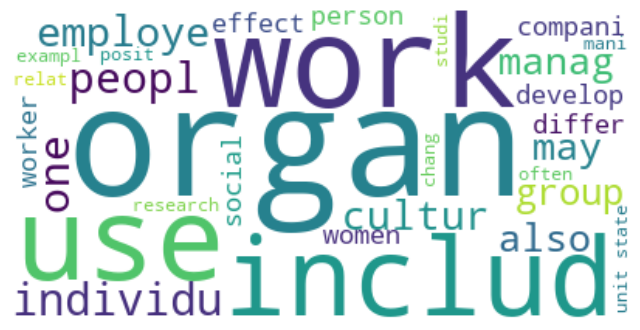

In [63]:
generate_wordcloud(content)

Generate Tokens Stats

In [64]:
output = 'output/token_table.csv'
generate_token_table(content_path, output)

Tableau sauvegardé dans output/token_table.csv


Similiratité entre 2 docs /avec 1 doc

In [65]:
print("Similarité entre doc 0 et doc 1 :", calculate_similarity(model, '0', '1'))
print("Documents similaires à doc 0 :", find_similar_docs(model, '0'))

Similarité entre doc 0 et doc 1 : 0.14680697
Documents similaires à doc 0 : [('144', 0.2913379669189453), ('92', 0.25693047046661377), ('135', 0.23658354580402374), ('172', 0.21328727900981903), ('59', 0.21239908039569855)]


Clustering

In [31]:
doc_vectors = StandardScaler().fit_transform(doc_vectors)
tfidf_vectors = StandardScaler().fit_transform(tfidf_matrix.toarray())
combined_vectors = np.hstack((doc_vectors, tfidf_matrix.toarray()))

optimal_k = find_optimal_clusters(combined_vectors, max_clusters=10, min_clusters=3)
print(f"Nombre optimal de clusters : {optimal_k}")

NameError: name 'doc_vectors' is not defined

In [ ]:
clusters, similarity_matrix = cluster_documents(content, optimal_k)
save_clusters_individually(clusters, "content3.json")

In [ ]:
clusters_dir = "output/clusters"
original_links_path = "links3.json"
output_dir = "cluster_links"

create_links_per_cluster(clusters_dir, original_links_path, output_dir)

JSON to GML

In [ ]:
links = "links3.json"
output_file = "outputgml/graph.gml"
json_to_gml(links, output_file)

Fichier GML créé : outputgml/graph.gml


In [ ]:
output_file1 = "outputgml/tokens_graph.gml"
output_file2 = "outputgml/clusters_graph.gml"
tokens_file = "output/cleaned_data.json"
clusters_file = "output/clusters.json"
json_to_gml(tokens_file, output_file1)
json_to_gml(clusters_file, output_file2)

Fichier GML créé : outputgml/tokens_graph.gml
Fichier GML créé : outputgml/clusters_graph.gml


In [ ]:
output_file = "outputgml/similarity_graph.gml"
generate_similarity_graph(content, similarity_matrix, output_file)

Graphe de similarité créé : outputgml/similarity_graph.gml


In [ ]:
num_clusters = find_optimal_clusters("content3.json", max_k=10)
for i in range(0,num_clusters):
    json_to_gml(f"cluster_links/cluster_{i}_links.json", f"outputgml/cluster_{i}.gml")

In [ ]:
print(analyze_page_sentiment("Sexual harassment", content))


{'page_name': 'Sexual harassment', 'sentiment_scores': {'positive': 0.04732241153342072, 'negative': 0.16626605504587172, 'neutral': 0.7824783748361731, 'compound': -0.3425870249017047}, 'overall_sentiment': 'Neutre avec consonance plus négative'}


In [ ]:
#A supprimer par la suite, juste j'ai essayé un truc
from sklearn.feature_extraction.text import TfidfVectorizer
import re

def preprocess_text(text):
    text = re.sub(r'\d+', '', text)  # Retirer les chiffres
    text = re.sub(r'\s+', ' ', text)  # Supprimer les espaces multiples
    return text.strip()

# Appliquer sur le contenu
content = {key: preprocess_text(value) for key, value in content.items()}
def tf(content):
    # Créer le vecteur TF-IDF
    vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
    X_tfidf = vectorizer.fit_transform(list(content.values()))
    
    # Extraire les termes et leurs spécificités (IDF)
    terms = vectorizer.get_feature_names_out()
    idf_values = vectorizer.idf_
    
    # Afficher la spécificité des mots
    print("Spécificité (IDF) des mots :")
    for term, idf in zip(terms, idf_values):
        print(f"{term}: {idf:.2f}")
    
    return X_tfidf  # Retourne la matrice TF-IDF pour d'autres usages


tf(content)


Spécificité (IDF) des mots :
aa: 5.85
aapi: 5.85
aarti: 5.34
aasce: 5.85
abacha: 5.85
abahlali: 5.85
abandon: 4.38
abandoned: 4.18
abandoning: 5.00
abandonment: 4.00
abasement: 5.16
abated: 5.16
abawi: 5.34
abbot: 5.34
abbott: 4.65
abbreviated: 5.34
abbreviation: 5.16
abbreviations: 5.56
abc: 5.00
abdelhadi: 5.85
abdomen: 5.85
abduction: 4.75
abducts: 5.16
aberbach: 5.85
aberle: 5.85
abide: 5.85
abilities: 3.12
abington: 5.85
able: 1.95
ableism: 4.65
ablution: 5.85
abnormal: 4.31
abnormality: 5.56
abolish: 4.38
abolished: 3.86
abolishing: 5.85
abolishment: 5.85
abolition: 4.24
abolitionism: 5.85
abolitionist: 4.87
abolitionists: 5.85
abomination: 5.34
aboriginal: 4.31
aboriginals: 5.56
aborigine: 5.85
aborigines: 5.00
abort: 5.56
abortion: 4.00
abortions: 5.56
abraham: 4.06
abrams: 5.56
abroad: 3.58
abrogated: 5.85
abs: 5.85
absence: 2.96
absences: 5.85
absent: 4.18
absentee: 5.16
absenteeism: 3.73
absolute: 3.42
absolutely: 5.56
absolutism: 5.85
absorb: 4.65
absorbed: 4.87
absorbing: 

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 294627 stored elements and shape (382, 19566)>